In [1]:
!pip install transformers
!pip install torch
!pip install einops

### Load dataset

In [2]:
import pandas as pd
import numpy as np

aml = pd.read_csv('combined_data.csv', sep=",", on_bad_lines="skip")
# Transpose the data
data = aml.transpose()
# Extract the first row and assign it as column names
data.columns = data.iloc[0]
data = data[1:]
# Reset index
data.reset_index(drop=True, inplace=True)
print(data.head())
print("\nMatrix dimensions:", data.shape)

Unnamed: 0 X..100130426 X..100133144 X..100134869  X..26823 X..340602  \
0             -16.60964     4.191342    -16.60964 -16.60964 -16.60964   
1             -16.60964    -16.60964     2.212292 -0.372748 -0.372748   
2             -16.60964    -16.60964    -0.385884 -0.385884  2.784108   
3              0.188287     1.823672     1.631016 -16.60964 -16.60964   
4             -16.60964    -16.60964     1.491089  2.298427  0.491094   

Unnamed: 0 X..388795 X..391343 X..391714 X..441362 X..652919  ... hsa.mir.942  \
0           3.402846 -16.60964 -16.60964 -16.60964  5.228819  ...    5.782562   
1           1.212264 -16.60964  2.797243 -16.60964   5.05359  ...    5.488771   
2           2.421536 -16.60964 -16.60964  1.936105 -16.60964  ...    2.727764   
3           1.145619 -16.60964  0.145625 -16.60964  3.302657  ...    7.015997   
4           1.491089 -16.60964  0.491094 -16.60964  5.948856  ...    5.369449   

Unnamed: 0 hsa.mir.943 hsa.mir.944 hsa.mir.95 hsa.mir.96 hsa.mir.98  \
0  

In [3]:
# Remove rows where the last column (Y) has NaN values
data = data.dropna(subset=[data.columns[-1]])

# Convert all data to numeric if necessary
data = data.apply(pd.to_numeric, errors='coerce')

# Define X: all columns from the second to the second-to-last
X = data.iloc[:, 0:-2]  # Excludes the first and the last two columns

# Define Y: last column (without modifications)
y = data.iloc[:, -1].astype(float)  # Ensure Y is numeric

print("X shape:", X.shape)
print("Y shape:", y.shape)

X shape: (159, 11705)
Y shape: (159,)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, chi2
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold
from scipy import stats

def get_p_values(X, y, method):
    """
    Compute p-values for feature selection using the specified method.
    """
    if method == 'anova':
        _, p_values = f_classif(X, y)
    elif method == 'chi2':
        _, p_values = chi2(X, y)
    else:
        raise ValueError("Invalid method. Choose 'anova' or 'chi2'.")

    return pd.Series(p_values, index=X.columns)

def comprehensive_feature_selection(X, y, threshold, method):
    """
    Perform feature selection using a specified method and threshold.
    """
    p_values = get_p_values(X, y, method)
    selected_features = p_values[p_values <= threshold].index
    X_filtered = X[selected_features]

    return {
        'p_values': p_values,
        'selected_features': selected_features,
        'X_filtered': X_filtered,
        'feature_count': len(selected_features)
    }

def plot_feature_distributions(p_values, threshold, method):
    """
    Plot p-value distributions for a given method.
    """
    plt.figure(figsize=(12, 5))
    plt.hist(p_values, bins=50, alpha=0.75)
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.title(f'{method} p-value Distribution')
    plt.xlabel('p-value')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

Creating synthetic dataset...
Dataset shape: (159, 11705)

Performing feature selection using anova...

Method: anova
Original number of features: 11705
Selected number of features: 1071
Reduction: 90.85%

Top 10 features by p-value:
Unnamed: 0
cg10152449     0.000002
cg23431721     0.000016
cg04857395     0.000029
hsa.mir.532    0.000030
cg17942750     0.000038
cg09936008     0.000043
cg27321949     0.000059
cg17134700     0.000073
cg27049094     0.000074
cg14473743     0.000092
dtype: float64


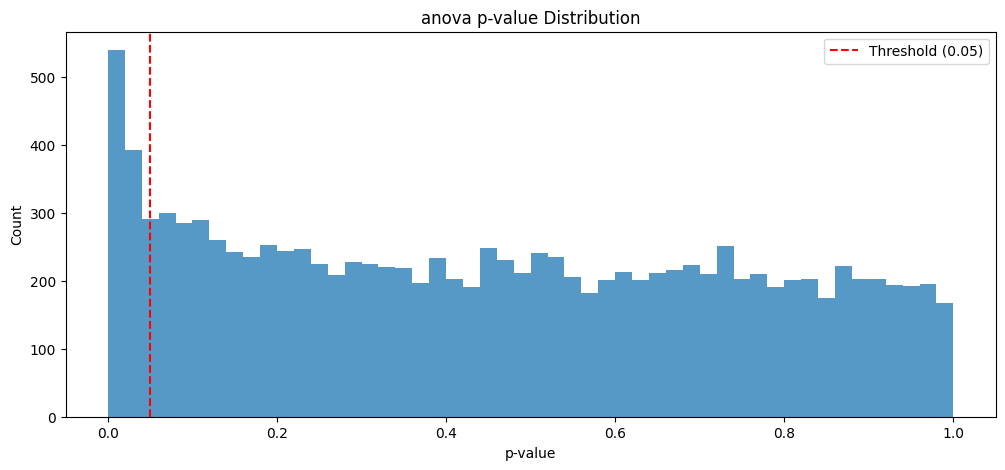


Filtered dataset saved to 'filtered_features_anova.csv'

Performing feature selection using chi2...

Method: chi2
Original number of features: 11705
Selected number of features: 96
Reduction: 99.18%

Top 10 features by p-value:
Unnamed: 0
UGT1A9.54600              0.002977
cg10152449                0.003159
SLC18A3.6572              0.003940
TEX101.83639              0.004327
PIWIL1.9271               0.006941
LOC100130238.100130238    0.007299
TNFSF18.8995              0.007369
PRAMEF20.645425           0.008425
hsa.mir.665               0.008557
OSTBETA.123264            0.008690
dtype: float64


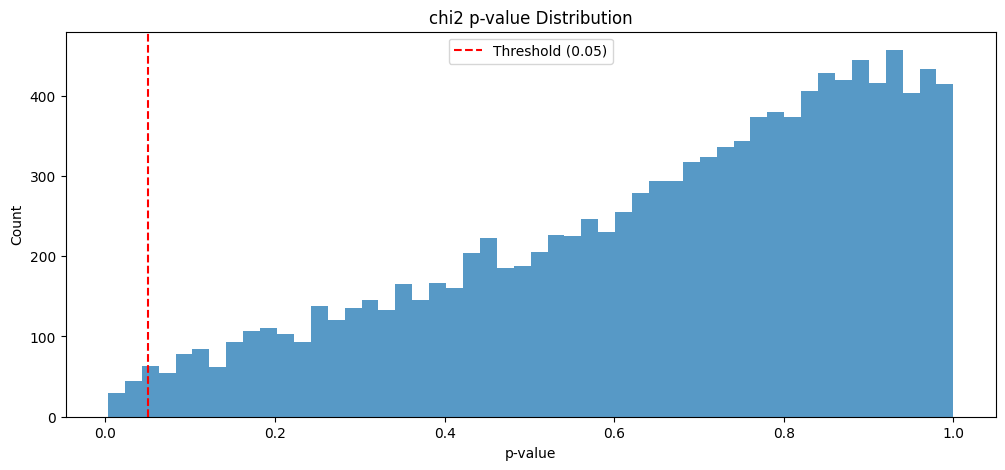


Filtered dataset saved to 'filtered_features_chi2.csv'


In [5]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler

# Create synthetic dataset
print("Creating synthetic dataset...")
print(f"Dataset shape: {X.shape}")

# Remove low variance features
selector = VarianceThreshold(threshold=0.0)
X_filtered_2 = selector.fit_transform(X)
X_filtered_2 = pd.DataFrame(X_filtered_2, columns=X.columns[selector.get_support()])

# Set p-value threshold
threshold = 0.05

# Perform feature selection for each method
methods = ['anova', 'chi2']
for method in methods:
    print(f"\nPerforming feature selection using {method}...")

    # Use different scalers for different methods
    if method == 'anova':
        scaler = StandardScaler()
    elif method == 'chi2':
        scaler = MinMaxScaler()

    X_scaled = pd.DataFrame(scaler.fit_transform(X_filtered_2), columns=X_filtered_2.columns, index=X_filtered_2.index)

    results = comprehensive_feature_selection(X_scaled, y, threshold, method)

    # Print results
    print(f"\nMethod: {method}")
    print(f"Original number of features: {X.shape[1]}")
    print(f"Selected number of features: {results['feature_count']}")
    print(f"Reduction: {(1 - results['feature_count'] / X.shape[1]) * 100:.2f}%")

    # Print top 10 features for the method
    print("\nTop 10 features by p-value:")
    print(results['p_values'].nsmallest(10))

    # Plot distributions
    plot_feature_distributions(results['p_values'], threshold, method)

    # Save filtered dataset
    X_filtered_copy = results['X_filtered'].copy()
    X_filtered_copy = X_filtered_copy.assign(Death=y)
    X_filtered_copy.to_csv(f'filtered_features_{method}.csv', index=False)
    print(f"\nFiltered dataset saved to 'filtered_features_{method}.csv'")